### Interpret Results

In [1]:
from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [100]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from src.dataset import load_dataset

In [13]:
data_dir = 'datasets_toy_regression/linear_regression_1'

train, test, labels = load_dataset(data_path=get_src_dir_path(data_dir), data_type="toy_regression", data_split_seed=0)

Text(0.5, 1.0, 'Train Data')

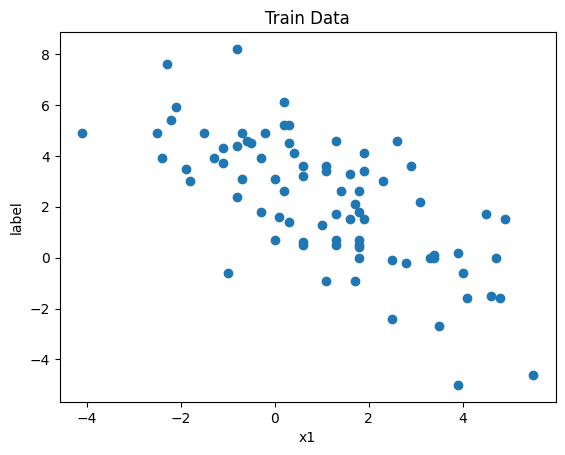

In [14]:
fig, ax = plt.subplots()

ax.scatter(train["x1"], train["label"])
ax.set_xlabel("x1")
ax.set_ylabel("label")
ax.set_title("Train Data")

### Hypothesis Testing

In [5]:
from src.prompt import ToyRegressionPrompt
from src.utils import ToyClassificationUtils, extract
from src.chat import chat_response_only
import scipy.stats as stats

prompter = ToyRegressionPrompt()

feature_columns = ToyClassificationUtils.get_feature_columns(train)

D_rows = train.sample(n=15, random_state=0)
D_feature_stds = D_rows[feature_columns].std().to_numpy()

D_note_label_df = D_rows[['note', 'label']]

x_row = ToyClassificationUtils.create_x_row_from_x_features("{'x1': [4.5]}", feature_columns)

In [46]:
prompt = prompter.get_general_prompt(D_note_label_df, x_row['note'][0], 1)

predictions = []
for i in range(100):
    response = chat_response_only(prompt, i)
    prediction = extract(response)
    predictions.append(prediction)


In [66]:
num_outliers_to_remove = int(0.03 * len(predictions))

outlier_free_predictions = np.sort(predictions)[num_outliers_to_remove:-num_outliers_to_remove]

mean = np.mean(outlier_free_predictions)
std = np.std(outlier_free_predictions)

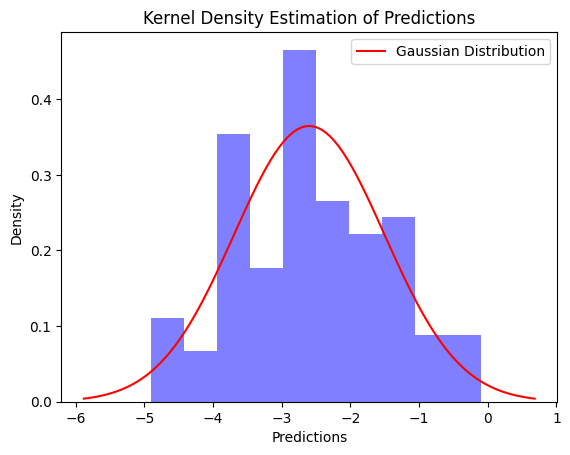

In [67]:
plt.figure()
# Plot kernel density estimation
plt.hist(outlier_free_predictions, bins=10, density=True, alpha=0.5, color='blue')
plt.title('Kernel Density Estimation of Predictions')
plt.xlabel('Predictions')
plt.ylabel('Density')

# Plot gaussian distribution
x = np.linspace(mean - 3*std, mean + 3*std, 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
plt.plot(x, y, color='red', label='Gaussian Distribution')

plt.legend()
plt.show()

In [68]:
from scipy import stats

print(stats.shapiro(outlier_free_predictions))

ShapiroResult(statistic=0.9859634932873585, pvalue=0.4159986001571069)


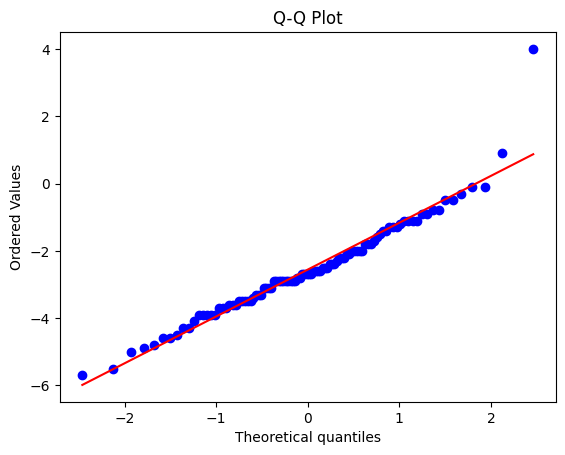

In [65]:
stats.probplot(predictions, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

#### Checking Tokenization

In [ ]:
import requests

# tokenize

url = "http://localhost:8000/tokenize"
headers = {"Content-Type": "application/json"}
data = {
    "model": "Qwen/Qwen2.5-14B",
    "prompt": prompt,
}

response = requests.post(url, headers=headers, json=data).json()

tokens = response["tokens"]

In [20]:

# detokenize

url2 = "http://localhost:8000/detokenize"
headers2 = {"Content-Type": "application/json"}

tokenized_prompt = []

for token in tokens:
    data2 = {
        "model": "Qwen/Qwen2.5-14B",
        "tokens": [token],
    }
    response2 = requests.post(url2, headers=headers2, json=data2).json()
    tokenized_prompt.append(response2["prompt"])


In [21]:
split_prompt_string = "|".join(tokenized_prompt)

#### Plotting

In [55]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from src.utils import ToyRegressionUtils
from csaps import csaps

from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank

In [85]:
results_directory = 'results/linear_regression_1/experiment_2/'

In [86]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_" in filename:
        save_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(save_data)

In [87]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        

In [ ]:
for save_data in df_list:
    # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=True, upper_bound_by_total_U=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=False, upper_bound_by_total_U=True, uncertainty_type="variance")

In [ ]:
feature_column = ToyRegressionUtils.get_feature_columns(D_data)[0]

x_x1_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_mean_list = []
prob_y_xz_std_list = []
prob_y_x_mean_list = []
prob_y_x_std_list = []
within_threshold_list = []

total_variance_list = []
aleatoric_variance_list = []

for z_df in df_list:
    try:
        x_x1 = z_df[f'x_{feature_column}'].values[0]
        x_x1_list.append(x_x1)
        total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append(z_df[f"z_{feature_column}"].values[min_Va_index])
        
        # get the prob_y_xz and prob_y_x
        prob_y_x_mean = z_df["p(y|x,D)_mean"].values[min_Va_index]
        prob_y_x_std = z_df["p(y|x,D)_std"].values[min_Va_index]
        prob_y_xz_mean = z_df["p(y|x,z,D)_mean"].values[min_Va_index]
        prob_y_xz_std = z_df["p(y|x,z,D)_std"].values[min_Va_index]
        
        prob_y_x_mean_list.append(prob_y_x_mean)
        prob_y_x_std_list.append(prob_y_x_std)
        prob_y_xz_mean_list.append(prob_y_xz_mean)
        prob_y_xz_std_list.append(prob_y_xz_std)
        
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
        
    except:
        pass
    
    try:
        
    
# Create a dataframe from the lists
data = {f'x_{feature_column}': x_x1_list,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        'z_value_for_min_Va': z_value_for_min_Va_list,
        'within_threshold': within_threshold_list,
        'prob_y_xz_mean': prob_y_xz_mean_list,
        'prob_y_xz_std': prob_y_xz_std_list,
        'prob_y_x_mean': prob_y_x_mean_list,
        'prob_y_x_std': prob_y_x_std_list,
        }

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by=f'x_{feature_column}')

In [90]:
# Remove min_Va if it is -inf

shots_df = shots_df[shots_df["min_Va"] != -np.inf]

     x_x1  total_uncertainty   min_Va   max_Ve  kl_pyx_pyxz  kl_pyxz_pyx  \
129 -15.0            4.06281  2.10192  1.96089     0.296297     0.721114   
83  -14.8            3.55835  2.03814  1.52021     1.143524    10.698120   
128 -14.4            3.80743  1.85809  1.94934     0.554459     0.251906   
112 -14.2            3.42718  1.76012  1.66706     0.159408     0.235772   
125 -14.0            5.23603  2.06803  3.16800     1.283126     0.422140   
..    ...                ...      ...      ...          ...          ...   
32   14.0            3.60036  2.18963  1.41073     0.307093     0.482815   
85   14.2            3.78303  2.07805  1.70498     1.366183     0.438236   
132  14.4            3.85693  2.24215  1.61478     0.443771     1.224319   
136  14.6            3.36415  2.22297  1.14118     0.013754     0.011855   
143  14.8            3.23577  2.25372  0.98205     0.227812     0.147853   

     z_value_for_min_Va                     within_threshold  prob_y_xz_mean  \
129    

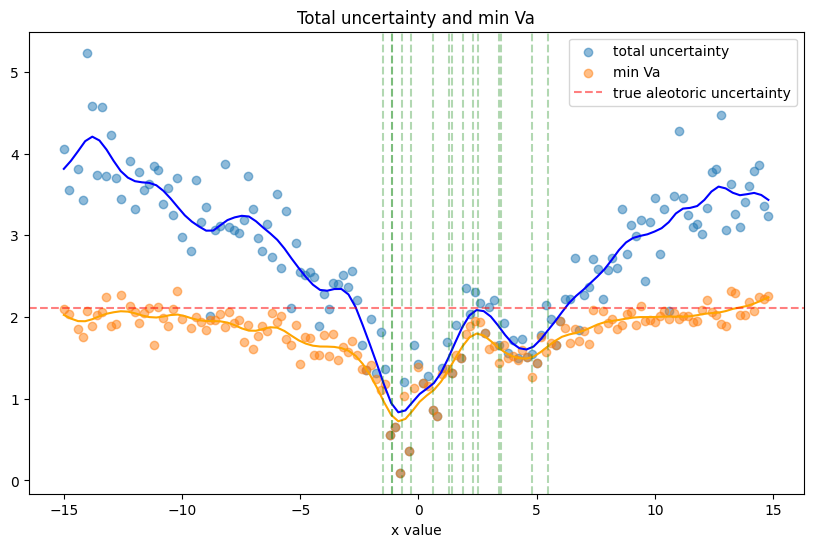

In [95]:
# plot x vs total uncertainty and min Va
# with csaps smoothing

plt.figure(figsize=(10, 6))

print(shots_df)

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], smooth=0.85)
y_min_Va = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va'], smooth=0.85)

plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], label='total uncertainty', alpha=0.5)
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va'], label='min Va', alpha=0.5)
plt.plot(x_grid, y_total_uncertainty(x_grid), color='blue')
plt.plot(x_grid, y_min_Va(x_grid), color='orange')

# vertical line for the true x
for i, row in D_data.iterrows():
    plt.axvline(x=row[feature_column], color='g', linestyle='--', alpha=0.3)
plt.title(f"Total uncertainty and min Va")

# if x value is at most 0.1 away from an icl value plot total uncertainty with a red colour
# icl_x1 = D_data[feature_column].values
# for i, row in shots_df.iterrows():
#     for j, icl_value in enumerate(icl_x1):
#         if abs(row[f'x_{feature_column}'] - icl_value) <= 0.15:
#             plt.scatter(row[f'x_{feature_column}'], row['total_uncertainty'], color='red')
#             break

# plt.yscale('log')

# horizontal line for the true aleotoric uncertainty
true_lower_std = 2
lower_entropy = 0.5 * np.log(2 * np.pi * np.e * true_lower_std**2)
plt.axhline(y=lower_entropy, color='r', linestyle='--', alpha=0.5, label='true aleotoric uncertainty') 

# true_upper_std = 2
# upper_entropy = 0.5 * np.log(2 * np.pi * np.e * true_upper_std**2)
# plt.axhline(y=upper_entropy, color='r', linestyle='--', alpha=0.5, label='true upper aleotoric uncertainty')

plt.xlabel('x value')
plt.legend()
plt.show()

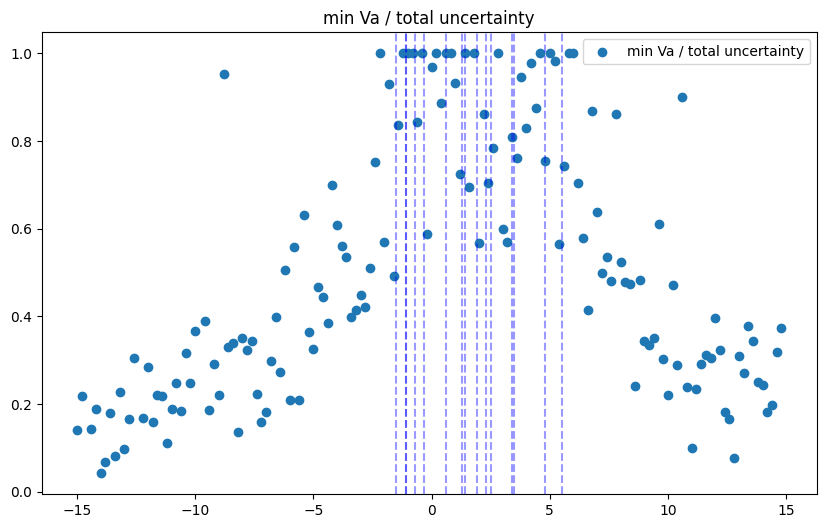

In [ ]:
# min Va total uncertainty ratio

shots_df['min_Va_total_uncertainty_ratio'] = np.exp(shots_df['min_Va'] - shots_df['total_uncertainty'])

plt.figure(figsize=(10, 6))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va_total_uncertainty_ratio'], label='min Va / total uncertainty')

# vertical line for the true x
for i, row in D_data.iterrows():
    plt.axvline(x=row[feature_column], color='b', linestyle='--', alpha=0.4)
plt.title(f"min Va / total uncertainty")

# if x value is at most 0.1 away from an icl value plot total uncertainty with a red colour
# icl_x1 = D_data[feature_column].values
# for i, row in shots_df.iterrows():
#     for j, icl_value in enumerate(icl_x1):
#         if abs(row[f'x_{feature_column}'] - icl_value) <= 0.15:
#             plt.scatter(row[f'x_{feature_column}'], row['min_Va_total_uncertainty_ratio'], color='red')
#             break

plt.legend()
plt.show()

Text(0.5, 1.0, 'mean and std of prob_y_x')

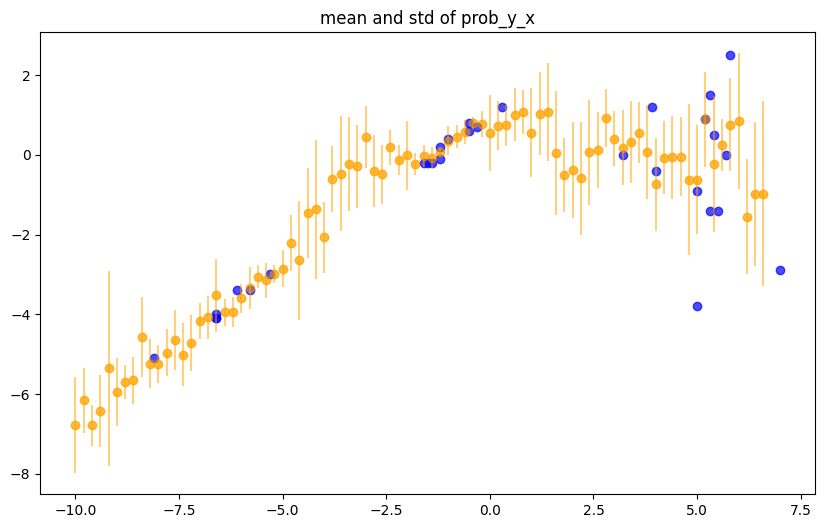

In [48]:
# plot mean of prob_y_x with std error 

plt.figure(figsize=(10, 6))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['prob_y_x_mean'], label='mean of prob_y_x', color='orange', alpha=0.5)
plt.errorbar(shots_df[f'x_{feature_column}'], shots_df['prob_y_x_mean'], yerr=shots_df['prob_y_x_std'], fmt='o', color='orange', alpha=0.5, label='std of prob_y_x')

# scatter plot for D
for i, row in D_data.iterrows():
    plt.scatter(row[feature_column], row['label'], color='b', alpha=0.7)
plt.title(f"mean and std of prob_y_x")
